# Fatbox to process Digital Elevation model - use manual mapping and automated fault analysis

The following IPython notebook detail how to **import manual fault mapping** in the workflow and perform automated **structural analysis** using Fatbox.

Inputs: small DEM of Magadi Natron basin (Eastern Africa Rift System).
DEM GLO30 open source worlwide dataset https://doi.org/10.5270/ESA-c5d3d65
30m of horizontal resolution.
The area present a large amount of normal faults.
For processing and demonstration purpose this guide use a 12km x 12km DEM.


Structure of the tutorial
- import
- mapping
- classification
- simplification + filtering
- analysis
- some plots to visualize the results.

Please read the tutorial main readme before you continue.


##Before the code: how to create and import your manual mapping.
You have maybe already work on your area on a GIS software, you mapped yourself by hand so you have an existing mapping of the faults.
Here we explain how to include your existing mapping in the algorithm, how to compare them to the semi-automated mapping made by Fatbox and how to get the automated structural analysis from your already very nice and time-consuming mapping.

### How to map using QGIS
(QGIS Geographic Information System. QGIS Association. http://www.qgis.org). This can be applied to any GIS software.

0. (If your mapping is a .kmz you need to convert it to shp using an online converter for exemple https://mygeodata.cloud/converter/kmz-to-geotif and skip the step 1)


1. **Draw your fault network** in a shapefile format, as multiline. (Guide QGIS https://docs.qgis.org/3.28/en/docs/training_manual/create_vector_data/create_new_vector.html )

2. Then we need to **rasterize the vector layer**. Use the tool ‘Rasterize (vector to raster)’ from QGIS package GDAL.

- *field to use for burn-in value* : **empty**, we want only the structures, they have no properties.
- *a fixed value to burn* : **1** (=value given to the pixels where a structures is there)
- *output raster size units* : georeferenced units
- *width/horizontal resolution* : for this one and the next write the same as the DEM. Check the  geographical resolution of the DEM with left click on  the layer -> ‘Properties’ -> ‘Information’ section ‘Information from provider’ field ‘Pixel size’.
- *height/vertical resolution* : same as DEM.
- *output extent* : from layer -> the small area frame. This has to be the area where you mapped (the frame is a shapefile polygone).
- *assign a specified nodata value to output bands* : **0** **very important** to have it to zero for the processing in fatbox.
- *output data type* : Float64
- *pre-initialize the output image with value* : **0**  (avoid problems in the algorithm, I am certain that what is not a line is 0)
- *Rasterized* : save to file -> select directory and name.

-> We get a raster that content the structures with value 1 and the background with value 0. It is a .tif file.

3. Convert to .geotiff (= tiff + geographical informations). On layer panel, left click on raster ‘Export’ -> ‘Save As…’   
Parameters:
- *format*: GeoTIFF
- file name: select directory and write the name of the new file
- CRS: same as layer (WGS84 in my case)
- extent: Coordinates of the area to process, should be an rectangle (very important)
- resolution: leave default (as you already set it in the rasterization)


### -> This geotiff can be directly imported in the following workflow to be process with Fatbox !

In [ ]:
#This cell is just for colab. In the final version the notebooks will run locally.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This cell is just for colab too
!pip install earthpy
!pip install cv-algorithms
!pip install vtk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cv-algorithms: filename=cv_algorithms-1.1.1-cp311-cp311-manylinux_2_35_x86_64.whl size=40945 sha256=a0ed711d680220d378ca58d629082ccf9b4a2322233815c953949d7012f1bc55
  Stored in directory: /root/.cache/pip/wheels/6d/fc/8d/7dc6a93ee79ff25fd3491eac76e255cca24893bb3d5f3cc150
Successfully built cv-algorithms
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 MB 7.4 MB/s eta 0:00:00


Import packages used in the tutorial.

In [ ]:
import math
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.close('all')
import numpy as np
from skimage.morphology import (skeletonize)
import time
import pickle
import statistics
from skimage import feature, morphology, filters
import cv2
import networkx as nx
from scipy.spatial import distance_matrix
import sys
import os
import earthpy
import earthpy.spatial
import earthpy.plot
from pathlib import Path #package used to make the gestion of path universal for all os

# Make modules as working directory
path_folder=Path('/content/drive/MyDrive/Fatbox')
path_folder=path_folder/'modules'
#print(path_folder) #make sure path_folder = '/Fatbox/modules'
os.chdir(path_folder) # make modules as working directory
#type pwd in console and make sure it is '/Fatbox/modules'

import preprocessing
import metrics
import plots
import utils
import structural_analysis
import edits

Path management

Parameters to save the plots

In [ ]:
#absolute path location of the DEM .tiff image
#DEM_path= Path('YOUR_PATH')

# Where to save the results of the processing
# sub folder will be created in this main folder
save_path = Path('/content/drive/MyDrive/Fatbox/tutorials/digital_elevation_models')

save_plots=True
my_dpi=400 #resolution to save the plots



########################
# Create directories to save the extraction.
if not (save_path/'array'/'extracted').is_dir():
    (save_path/'array'/'extracted').mkdir(parents=True,exist_ok=True)

if not (save_path/'images'/'extracted').is_dir():
    (save_path/'images'/'extracted').mkdir(parents=True,exist_ok=True)

# Create directories to save the analysis.
if not (save_path/'array'/'analyzed').is_dir():
    (save_path/'array'/'analyzed').mkdir(parents=True,exist_ok=True)

if not (save_path/'images'/'analyzed').is_dir():
    (save_path/'images'/'analyzed').mkdir(parents=True,exist_ok=True)

# Path where the plots of the extraction are saved
loc_map=(save_path/'images'/'extracted') #do not modify, this is a shortcut
# Path where the plots of the analysis are saved
loc_analyse=(save_path/'images'/'analyzed') #do not modify, this is a shortcut

## Mapping


First we import the DEM.
The DEM is a .tiff file. The data extraction create 3 np.arrays:
- Elevation (=img_dem)
- Latitudes
- Longitudes.
You can extract a small rectangle if you want, instead of your entire geotiff.
Enter the coordinates of the rectangle that you want (like bellow).

The data extraction takes a while so better to extract once and save the arrays.


In [ ]:
##### Import the DEM #####

# Coordinates area to extract
# in my case the small I use regularly bc quick to run.
coord_north=-1.3356 #unit [°]
coord_south=-1.4436 #unit [°]
coord_west=36.4183 #unit [°]
coord_east=36.5497 #unit [°]

#img_dem, latitudes, longitudes = preprocessing.extract_geotiff_and_coord (DEM_path,coord_north=coord_north,coord_south=coord_south,coord_west=coord_west,coord_east=coord_east,system='geographic')

# np.save((loc_map/'img_dem.npy'),img_dem)
# np.save((loc_map/'latitudes.npy'),latitudes)
# np.save((loc_map/'longitudes.npy'),longitudes)

# It is faster to load the extracted DEM instead of extracting every time
path_input=Path('/content/drive/MyDrive/Fatbox/tutorials/digital_elevation_models/data_dem')

img_dem=np.load((path_input/'img_dem_glo_small.npy'))
lat=np.load((path_input/'latitudes_glo_small.npy'))
long=np.load((path_input/'longitudes_glo_small.npy'))

sy_dem=np.size(img_dem,0)
sx_dem=np.size(img_dem,1)

resolution=30 #!!! enter horizontal resolution of the DEM


## Extract the mapping made by hand.

The hand map is a geotiff, a black and white array. Black is the location of a structure.
White is the background. (Like the skeleton in the automated mapping).
*Warning: I did this mappig quickly for illustration purpose.*

1) Extraction of the geotiff with the usual function.

2) Connection detection.

3) Graph creation.

After that, the workflow is exactly the same as automated mapping.

In [ ]:
#paste absolute path of your geotif

path_hand_map= Path ('/content/drive/MyDrive/Fatbox/tutorials/digital_elevation_models/data_dem/hand_map_GLO_resolution.tif')


hand_map_raster, latitudes_hand_map, longitudes_hand_map= preprocessing.extract_geotiff_and_coord(path_hand_map,coord_north=coord_north,coord_south=coord_south,coord_west=coord_west,coord_east=coord_east,system='geographic')



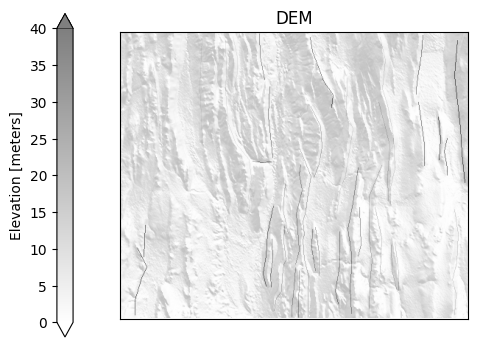

In [ ]:
fig, axs = plt.subplots(figsize=(6,6))
hillshade = earthpy.spatial.hillshade(img_dem)
earthpy.plot.plot_bands(
    hillshade, cbar=False, ax=axs,alpha=0.5
    )
cp=axs.imshow(hand_map_raster, 'gray_r', alpha=0.5)
axs.set_title('DEM')
cbar=plt.colorbar(cp,location='left',extend='both', spacing='proportional',
                    shrink=0.7, label='Elevation [meters]')

Extraction of the network

In [ ]:
# Make in format that network can process
ret, markers = cv2.connectedComponents(hand_map_raster.astype('uint8'))

save_connection=False
if save_connection==True:
  loc=(save_path/'array'/'extracted') #do not modify, this is a shortcut
  np.save((loc/str('hand_map_markers_ret='+str(ret))),markers)

###############################################
##########  CLASSIFICATION ####################

# Build graph
G = nx.Graph()

node = 0
for comp in range(1,ret):

    points = np.transpose(np.vstack((np.where(markers==comp))))

    for point in points:
        G.add_node(node)
        G.nodes[node]['pos'] = (point[1], point[0])
        G.nodes[node]['component'] = comp
        node += 1


### Parameter ## !!!!
distance_threshold = 1.5
###
for comp in range(1,ret):

    points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
    nodes  = [node for node in G if G.nodes[node]['component']==comp]

    dm = distance_matrix(points, points)  #

    for n in range(len(points)):
        # print(n)
        for m in range(len(points)):

            if dm[n,m]<distance_threshold:
                G.add_edge(nodes[n],nodes[m])

G = edits.label_components(G)

G = edits.remove_self_edge(G)

In [ ]:
# Load G auto

load_filtered_classification=True
if load_filtered_classification==True:
    loc=(save_path/'array'/'extracted') #do not modify, this is a shortcut
    G_auto=pickle.load(open( (loc/'GGLO_filtered_3.pickle'), 'rb'))

Now you have a network!

Plots the fault extraction

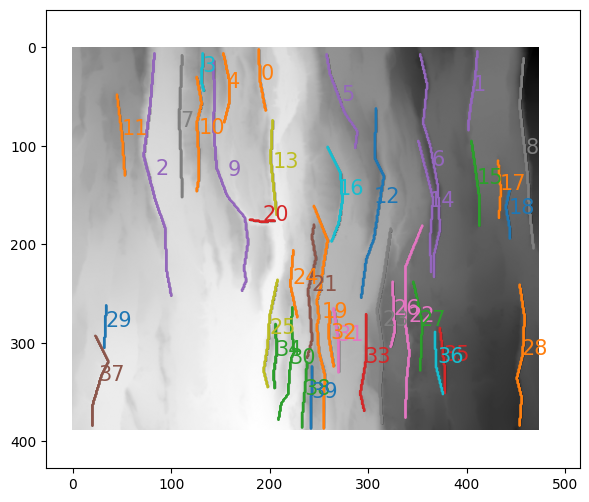

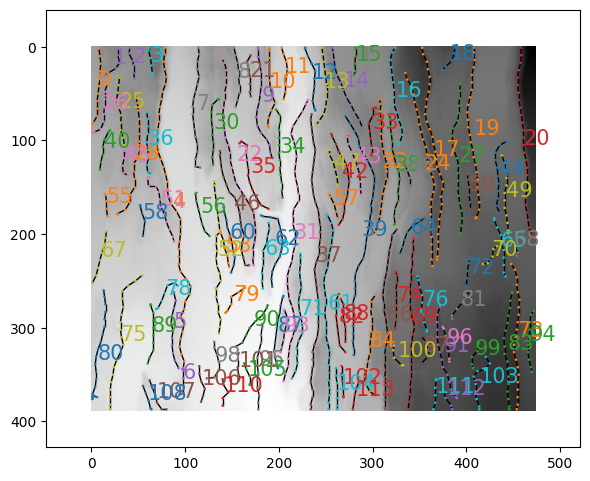

In [ ]:
# Plot network hand map
fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.imshow(img_dem,cmap=cm.gray_r) #Background DEM
plots.plot_components(G,True,ax=axs,node_size=0.8)
plt.tight_layout()
if save_plots: plt.savefig((loc_map/'G_hand.png'),dpi=my_dpi)

fig, axs = plt.subplots(1, 1, figsize=(6,6))
axs.imshow(img_dem,cmap=cm.gray_r) #Background DEM
plots.plot_components(G_auto,True,ax=axs,node_size=0.8)
plt.tight_layout()
if save_plots: plt.savefig((loc_map/'G_GLO.png'),dpi=my_dpi)

Comparison automated and manual mapping. Obviously I did a quick manual mapping just to show in the tutorials so the mapping is very approximative.

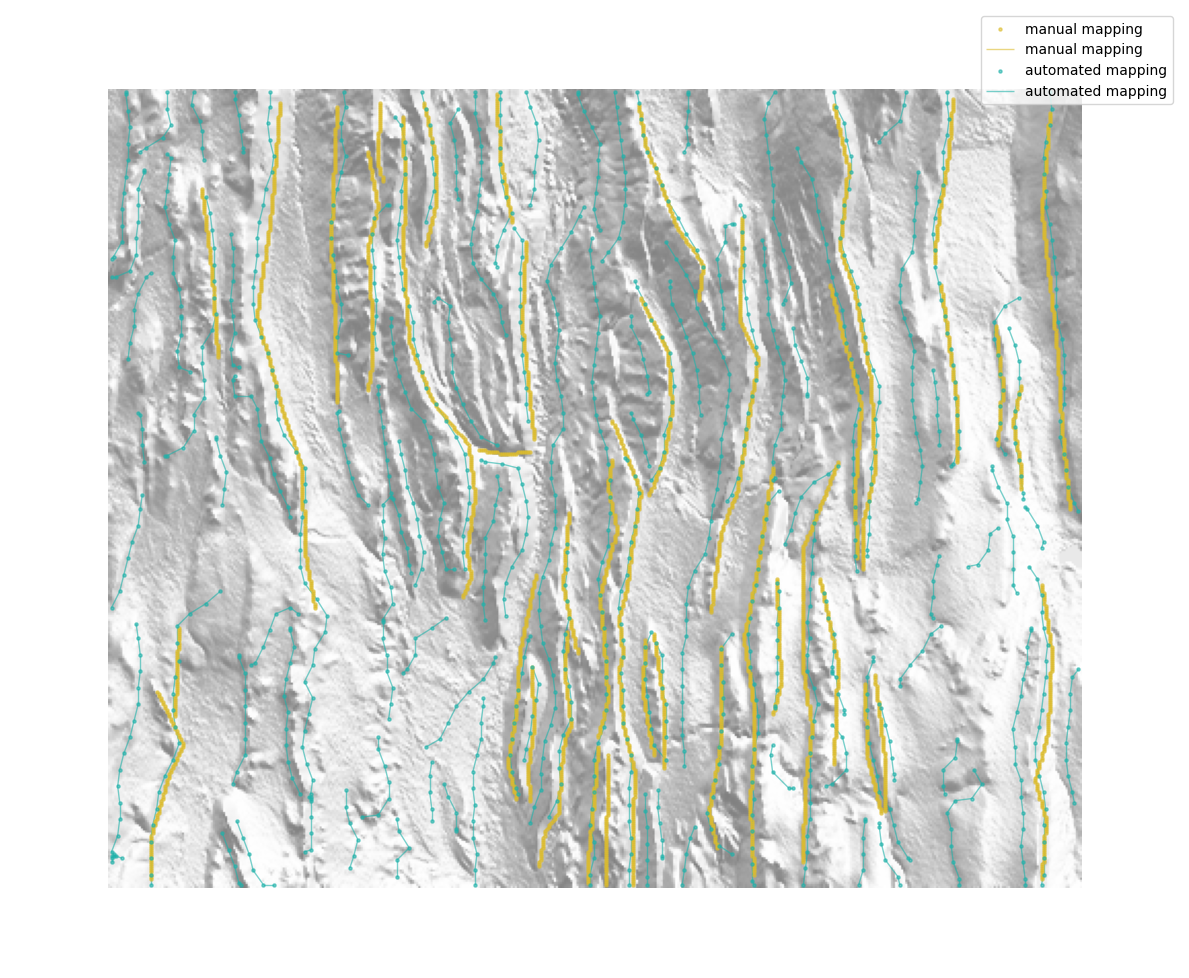

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(12,12) )
# white=np.zeros(np.shape(img_dem))
# axs.imshow(white,cmap=cm.gray_r,alpha=0)
axs.axis('on')  # turns on axis
axs.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
hillshade = earthpy.spatial.hillshade(img_dem)
earthpy.plot.plot_bands(
    hillshade, cbar=False, ax=axs,alpha=0.5
    )

#draw manual mapping
nx.draw(G,
        pos=nx.get_node_attributes(G, 'pos'),
        node_color='#DCBC2E',edge_color='#DCBC2E',
        node_size=5, alpha= 0.6,label='manual mapping')
# alpha control transparency

# draw automated mapping
nx.draw(G_auto,
        pos=nx.get_node_attributes(G_auto, 'pos'),
        node_color='#20b2aa',edge_color='#20b2aa',
        node_size=5, alpha= 0.6, label='automated mapping')

axs.legend(loc='best')
plt.tight_layout()

## Border processing



Here we process the border to avoid bugs in the analysis.

1) *simplify* : remove one node out of [parameter]. This makes the network lighter, and I don't need so much detail. You can keep full resolution and skip this step.

2) *strike_edges* and *compute_edge_length* : compute azimuth of edges and edges length. The edges need to have these properties (J.edges[edge]['strike'] and J.edges[edge]['length']) to compute the next function.

3) *filter_out_edges*: remove the edges for which an extremitiy of the cross section will be out of the DEM. This avoid the bug of the analysis.

4) *remove_small_components* : Because we removed some edges in step 3, some components can have now very few nodes, maybe even only one node. This makes no sense to analyse a component with so few nodes, that means a very very short fault. So better to get ride of them.

5) *label_components*: Relabel the components to have consecutive labels (= don't have label that corresponds to no structure).

NB: To analyse the fault next to the borders, increase the area size or use a tile that overlap the border.

In [ ]:
J=G.copy()

##### Filter the border to avoid the bugs. #####
J=edits.simplify(J,3)
J=structural_analysis.strike_edges(J)
J=metrics.compute_edge_length(J)
# From here you can plot the rose of strike without further analysis

J=structural_analysis.filter_out_edges(J, img_dem, d=12) # !!! setting of d !


J=edits.remove_small_components(J,3)
J=edits.label_components(J)

Number of edges removed : 10
Number of nodes removed : 10


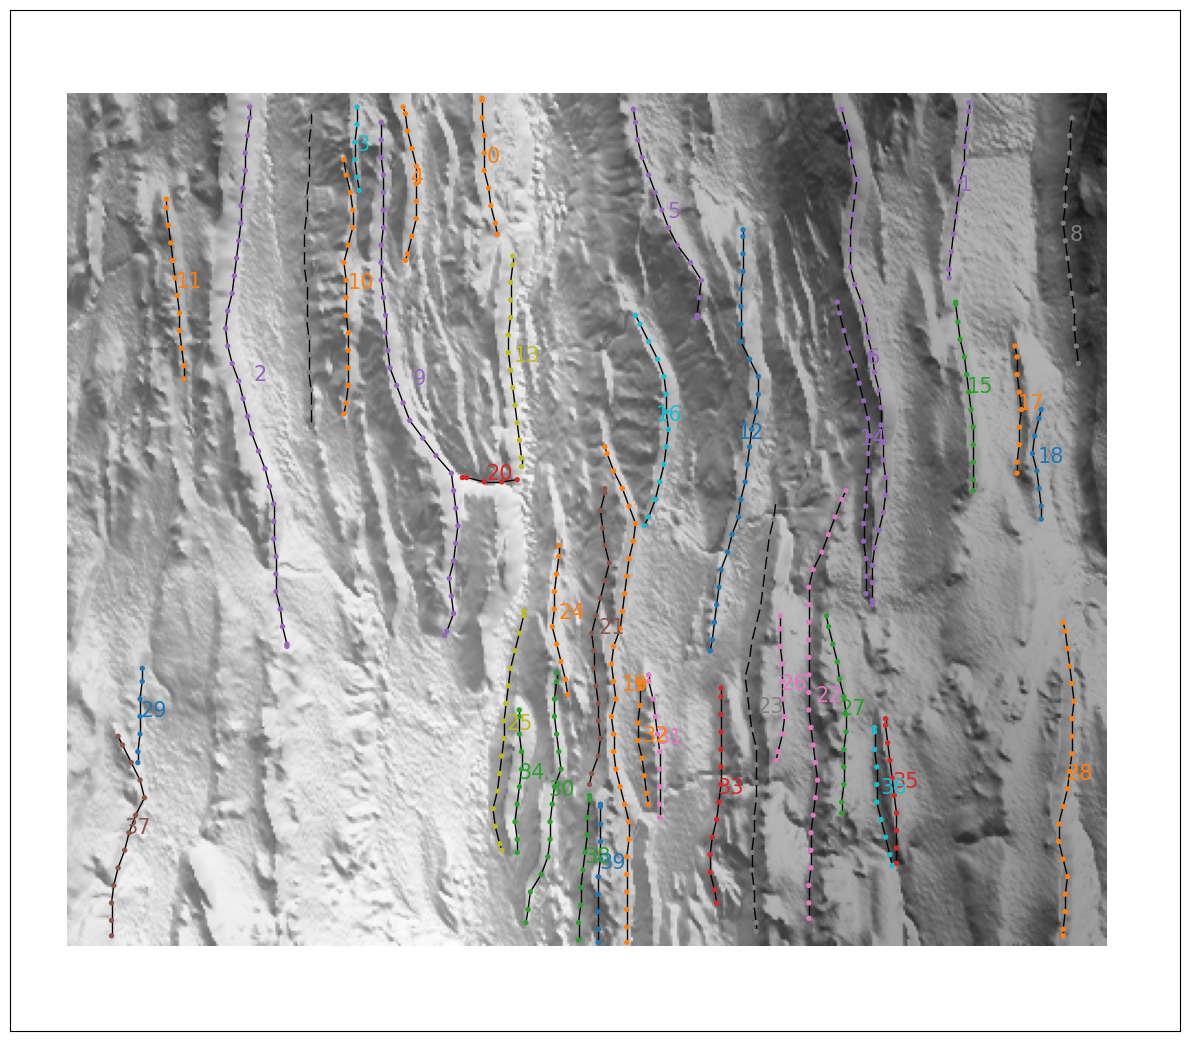

In [ ]:
# Plot filtered network over hillshade

fig, axs = plt.subplots(1,1, figsize=(12,12) )

axs.imshow(img_dem, 'gray_r')
hillshade = earthpy.spatial.hillshade(img_dem)
earthpy.plot.plot_bands(
    hillshade, cbar=False, ax=axs,alpha=0.5
    )
plots.plot_components(J,label=True,node_size=8,ax=axs)
plt.tight_layout()
if save_plots: plt.savefig((loc_map/'J_border_processed.png'),dpi=my_dpi)

## Structural analysis


In [ ]:

# Need to have compute strike and length before run the structural analysis.
# Compute strike using structural_analysis.strike_edges

# SETTINGS # !!!!
######
d=12 #[pixels]
######
pix_size=resolution #horizontal resolution of the DEM
dip_constrain=60
use_natural_dip=False # If use natural_dip=False, the constrain dip is used.
######

# Explanation dip constrain: sometimes fault scarp are eroded
# thus the measured fault dip is low and extension will be overestimated.
# When the dip is really low, I recommend to constrain the dip
# to compute the extension and displacement (the throw is measured).


list_labels=metrics.get_component_labels(J)

summary_matrix=np.zeros((len(list_labels),7))

extremities=np.zeros((len(list(J.edges)),4))
k=0
i=0

list_edge=[]
list_dip_all=[]

for label in list_labels:
    nodes = [node for node in J if J.nodes[node]['component']==label]
    K=nx.subgraph(J,nodes) # K is a subgraph containing only one component
    # print(label) #help to debug

    #Print progression of analysis  // ajust the step if needed // # !!!!
    if len(list_labels)<=200 and (i in np.arange(10,210,10)):
        print(i)
    elif len(list_labels)>200 and (i in np.arange(200,max(list_labels),50)) :
        print(i)

    summary_matrix[i,0]=label

    length=0
    list_extension=[]
    list_throw=[]
    list_disp=[]
    list_strike=[]

    for edge in K.edges:
        list_edge.append(edge)
        list_th=[]
        list_kmax_throw=[] #kmax is index on section where throw is maximum

        ###
        # Cross section on center of segment with d from center to each side
        ###

        # Extract grid coord and altitudes of cross-section
        x0, y0 = K.nodes[edge[0]]['pos']
        x1, y1 = K.nodes[edge[1]]['pos']

        strike=K.edges[edge]['strike']
        list_dip_label=[]

        #initialisations of beginning of loop
        all_x=np.zeros([2*d+1,1]) #x coordinates of profile
        all_y=np.zeros([2*d+1,1]) #y coordinates of profile
        alt=np.zeros([2*d+1,1])

        ################################
        # compute coordinates and gather altitudes of the profile
        # perpendicular to the segment, in its middle M, with length d on each side

        #compute the coordinates of the middlepoint of each segment
        midpoint_x=(x0+x1)/2
        midpoint_y=(y0+y1)/2

        all_x[d,0]=midpoint_x
        all_y[d,0]=midpoint_y
        midpoint_xx=math.floor(midpoint_x+0.5)
        midpoint_yy=math.floor(midpoint_y+0.5)
        alt[d,0]=img_dem[midpoint_yy,midpoint_xx]

        list_dip_edge=[]
        #loop cross section. Pull apart from M, to M + d and M - d
        #cross section orthogonal to the fault segment
        for n in range (1,d+1):

            xD,yD,xE,yE=structural_analysis.calcul_coordinates(np.radians(strike), midpoint_x, midpoint_y, n)

            all_x[d-n,0]=xD
            all_y[d-n,0]=yD
            all_x[d+n,0]=xE
            all_y[d+n,0]=yE

            # ROUND OF COORDINATES
            #goal of those 4 lines is to have the coord of the pixel where the points are
            #it have to be an int because img_dem[x,y] can take only int

            xD=math.floor(xD+0.5)
            yD=math.floor(yD+0.5)
            xE=math.floor(xE+0.5)
            yE=math.floor(yE+0.5)

            alt[d-n,0]=img_dem[yD,xD]
            alt[d+n,0]=img_dem[yE,xE]

            throw=img_dem[yD,xD]-img_dem[yE,xE]
            list_th.append(abs(throw))

            dip_rad=np.arctan( (throw) / (2*n*pix_size) )
            dip_dg=np.degrees(dip_rad)

            list_dip_edge.append(dip_dg) #abs(dip_dg)


        xD,yD,xE,yE=structural_analysis.calcul_coordinates(np.radians(strike), midpoint_x, midpoint_y, d)

        extremities[k,0]=xD
        extremities[k,1]=yD
        extremities[k,2]=xE
        extremities[k,3]=yE

        m=max(list_th)
        kmax=list_th.index(m)+1
        list_kmax_throw.append(kmax)
        throw= abs (max (list_th))

        dip_rad=np.arctan( (throw) / (2*n*pix_size) )
        dip_dg=np.degrees(dip_rad)

        #list_throw.append(throw)
        list_dip_all.append(max(list_dip_edge))
        list_dip_label.append(max(list_dip_edge))

        if use_natural_dip==False:
            dip=dip_constrain

        extension= throw / (np.tan(np.radians(abs(dip))))
        displacement= np.sqrt( np.square(throw) + np.square(extension) )

        J.edges[edge]['extension'] = extension
        J.edges[edge]['throw'] = throw
        J.edges[edge]['displacement'] = displacement

        if use_natural_dip==True: J.edges[edge]['natural_dip'] = dip_dg #max(list_dip_edge)

        list_strike.append(strike)
        list_extension.append(extension)
        list_throw.append(throw)
        list_disp.append(displacement)
        length=length+J.edges[edge]['length']

        if img_dem[math.floor(yD+0.5),math.floor(xD+0.5)]<img_dem[math.floor(yE+0.5),math.floor(xE+0.5)]: #pend vers ouest
            J.edges[edge]['dip_direction']='west'
        else:
            J.edges[edge]['dip_direction']='east'


        k=k+1


    summary_matrix[i,1]=np.mean(list_strike)
    summary_matrix[i,2]=length
    summary_matrix[i,3]=max(list_dip_label)
    summary_matrix[i,4]=np.mean(list_throw)
    summary_matrix[i,5]=np.mean(list_extension)
    summary_matrix[i,6]=max(list_disp)

    i=i+1

#Summary matrix content
#This matrix provide a summary of the properties of the entire component

#column0=label                (no unit)
#column1=mean strike          (unit degrees)
#column2=total length         (unit pixels or meters depending how length was computed)
#column3=maximum natural dip  (unit degrees)
#column4=mean throw           (unit meters)
#column5=mean extension       (unit meters)
#column6=maximum displacement (unit meters)


# The analysis insert attribute to the edges:
# J.edges[edge]['dip_direction']
# J.edges[edge]['extension']
# J.edges[edge]['throw']
# J.edges[edge]['displacement']
# if relevant J.edges[edge]['natural_dip']
# In addition, computed before:
# J.edges[edge]['strike']
# J.edges[edge][length']

10
20
30


Save analysis

In [ ]:
#Save or load analysis
#SAVE
save_analysis=False
if save_analysis==True:
    # save graph object to file
    loc=(save_path/'array'/'analyzed') #do not modify, this is a shortcut
    pickle.dump(J, open( (loc/'J_hand_analyzed.pickle'), 'wb'))
    np.save(loc/'hand_summary_matrix', summary_matrix)

#LOAD
load_analysis=False
if load_analysis==True:
    loc=(save_path/'array'/'analyzed') #do not modify, this is a shortcut
    J=pickle.load(open( (loc/'J_hand_analyzed.pickle'), 'rb'))
    summary_matrix=np.load(loc/'hand_summary_matrix')

# Plot the results of the analysis.
There is many plots possible, here are a few possible.

This is the exact same as the automated mapping.

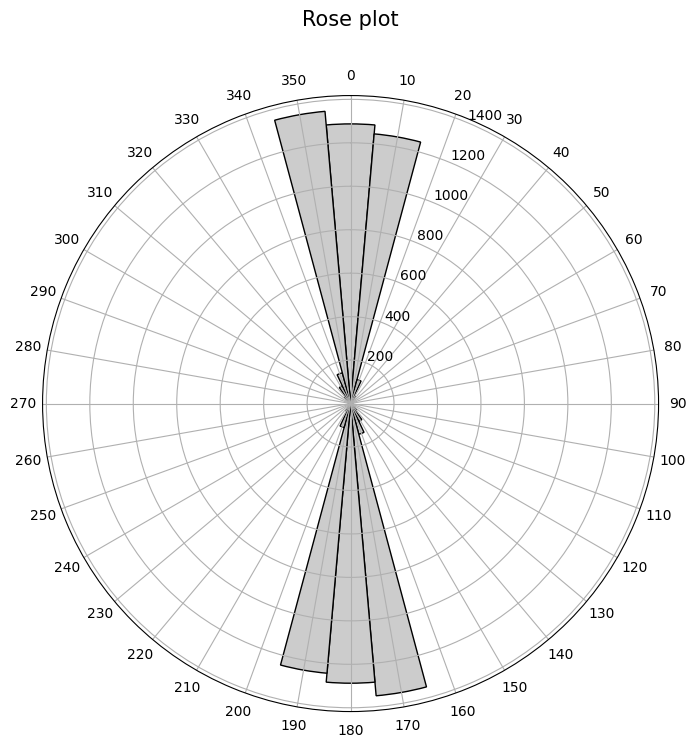

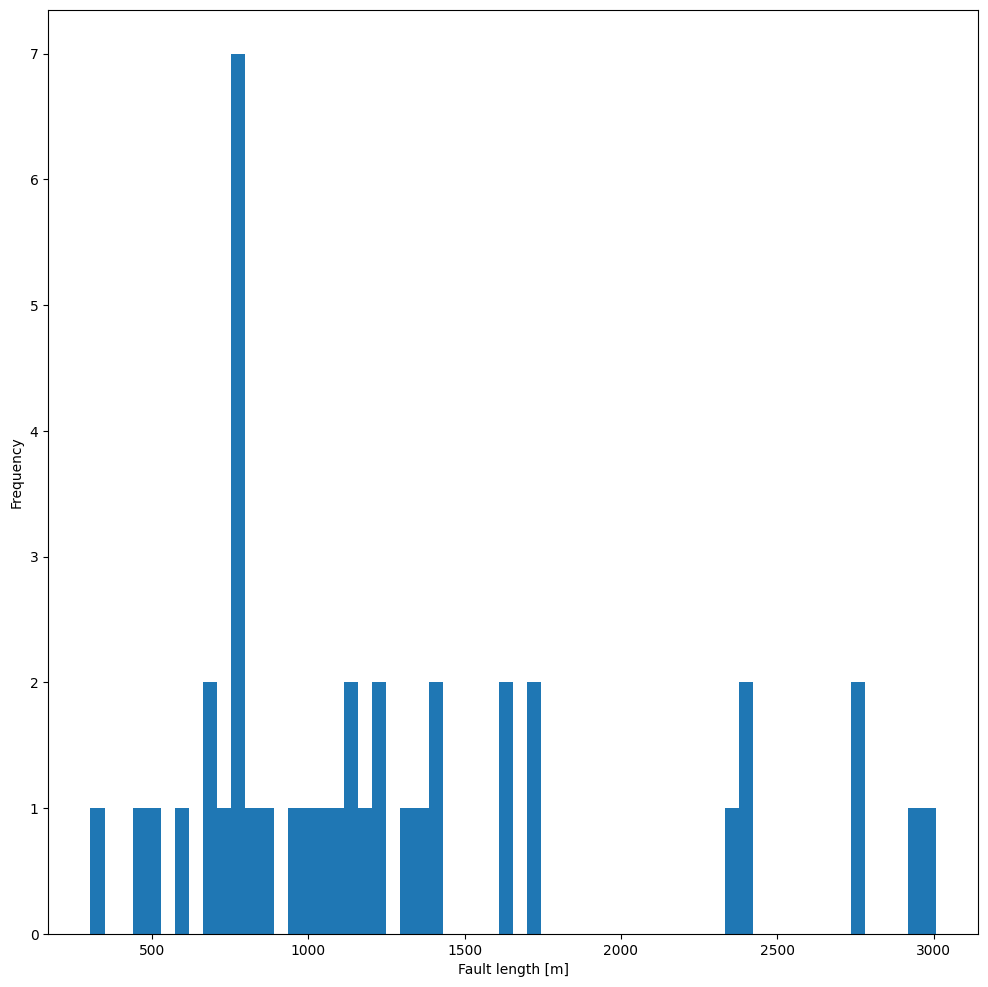

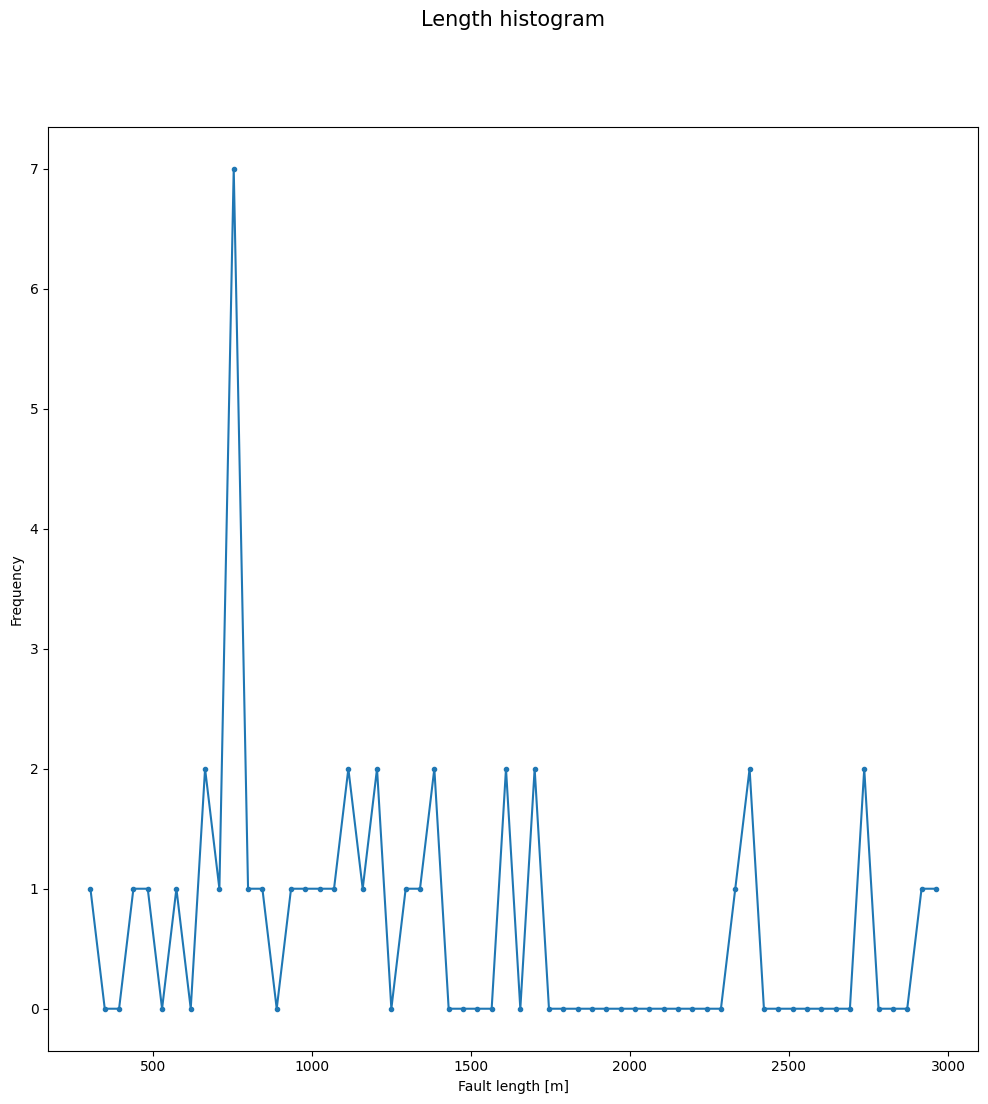

In [ ]:
#Rose and length histogram
###  Rose diagram  ###
ax=plots.plot_rose_diagram(J)
if save_plots: plt.savefig((loc_analyse/'Rose_plot.png'),dpi=my_dpi)


###  Length distribution histogram ###
list_labels=metrics.get_component_labels(J)
fig1,fig2=plots.plot_length_histogram (J, list_labels, resolution=12, title='Length histogram')
if save_plots: fig1.savefig((loc_analyse/'Length_histogram_bars.png'),dpi=my_dpi)
if save_plots: fig2.savefig((loc_analyse/'Length_histogram_dots.png'),dpi=my_dpi)

r2=0.9764589711860415
eq_fit : y= 61.975 exp(-0.000426*x)


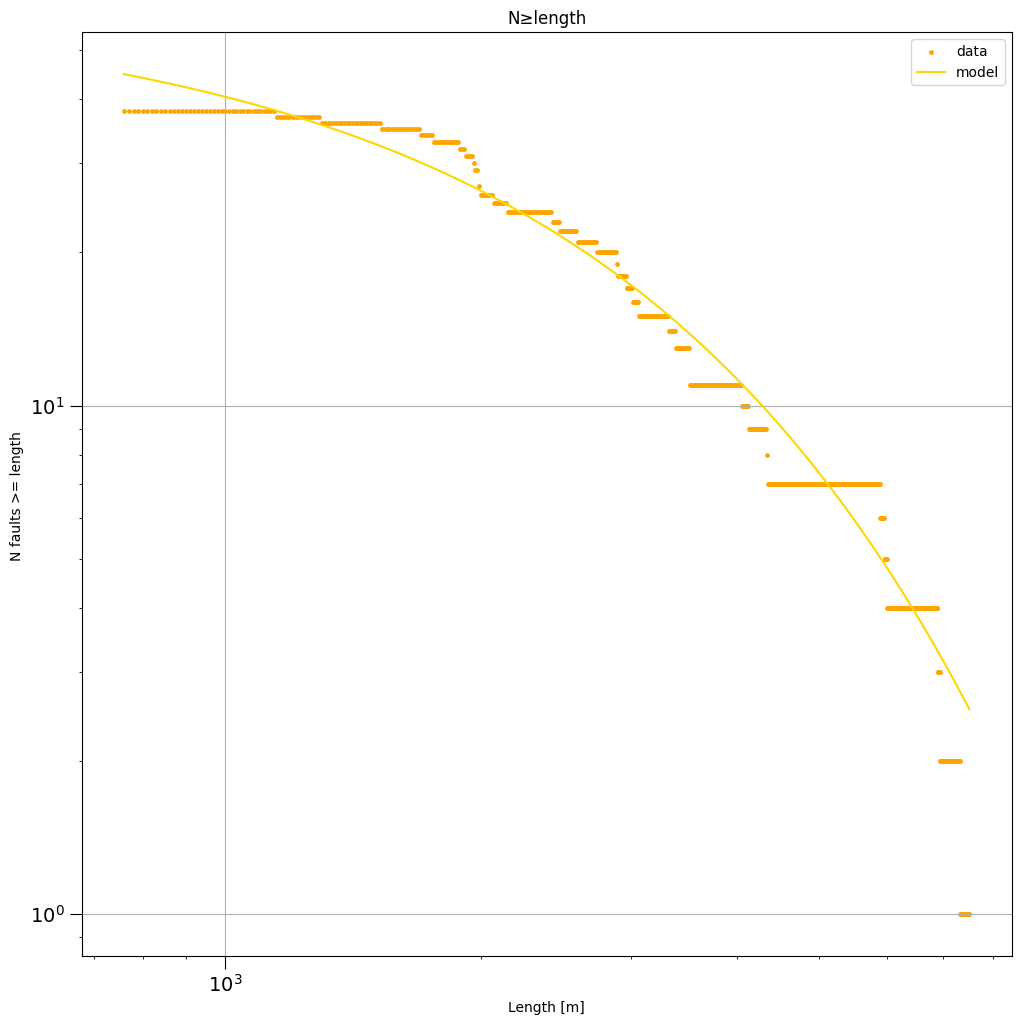

In [ ]:
#N≥length
### Plot number of components with length > length in abscissa.
# This gives the repartition of components lengths.

length_per_labelJ=plots.length_histo_computation(J,list_labels,resolution) # here conversion pixels to meters

max_length=max(length_per_labelJ[:,1])
min_length=min(length_per_labelJ[:,1])
length_ranges=np.arange(round(min_length),round(max_length),10 ) # try different step

Nlength=np.zeros((len(length_ranges),2))
for r in range(0,len(length_ranges-1)):
    Nlength[r,0]=length_ranges[r]
    n=0
    for l in range (0, len (length_per_labelJ [:,0])-1):
        length=length_per_labelJ[l,1]

        if length >= length_ranges[r]:
            n=n+1
    Nlength[r,1]=n


nlength0_log=np.log(Nlength[:,0])
nlength1_log=np.log(Nlength[:,1])

square=np.polyfit(nlength0_log,nlength1_log,2)
xp = np.linspace(round(min_length),round(max_length), 10000)
p = np.poly1d(square)

import scipy
from sklearn.metrics import r2_score

def exp_fit (x,a,alpha):
    return a*np.exp(alpha*x)
eq=scipy.optimize.curve_fit(exp_fit,Nlength[:,0],Nlength[:,1],p0=[1154.2,-0.0001])
eq=eq[0]
y_eq=eq[0]*np.exp(eq[1]*Nlength[:,0])
r2=r2_score(Nlength[:,1], y_eq)
print(str('r2='+str(r2)))
print(str('eq_fit : y= '+str(round(eq[0],3))+' exp('+str(round(eq[1],7))+'*x)'))

fig, axs = plt.subplots(1,1, figsize=(12,12))
axs.scatter(Nlength[:,0], Nlength[:,1],s=6,c='orange',label='data')
axs.plot(Nlength[:,0], y_eq,c="gold",label='model')
axs.set_xscale('log')
axs.set_yscale("log")
axs.grid(True)
axs.set_ylabel('N faults >= length ')
axs.set_xlabel('Length [m]')
axs.tick_params(labelsize=14,length=9)
axs.legend(loc='best')
axs.set_title('N≥length')

if save_plots: plt.savefig((loc_analyse/'Nlength.png'),dpi=my_dpi)

In [ ]:
# Plot edge attribute
### Edge attribute plots ###
fig, axs = plt.subplots(1, 1, figsize=(12,12))
axs.imshow(img_dem,cmap=cm.gray_r)
plots.plot_edge_attribute_other_version(J, 'extension', ax=axs) #try 'throw' 'displacement' to display these attributes
axs.set_title('Extension over DEM')
if save_plots: plt.savefig((loc_analyse/'edge_extension.png'),dpi=my_dpi) #replace name by attribute

In [ ]:
###  Displacement Length scattering of whole network ###

#Compute D/L matrix for whole network
list_labels=metrics.get_component_labels(J)

disp_length=np.zeros((len(list_labels),2))
ii=0
for label in list_labels:
    nodes = [node for node in J if J.nodes[node]['component']==label]
    K=nx.subgraph(J,nodes)
    list_disp=[]

    length=0
    for edge in K.edges:
        #print(K.edges[edge]['displacement'])
        list_disp.append(K.edges[edge]['throw'])
        length=length+(K.edges[edge]['length']*resolution)


    disp_length[ii,0]=length
    disp_length[ii,1]=max(list_disp) #this is a big hypothesis
    ii=ii+1


## Plot D/L scattered
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.scatter(disp_length[:,0],disp_length[:,1],c=np.random.rand(len(disp_length[:,0]),3))
ax.set_xlabel('Length [meters]')
ax.set_ylabel('Maximum displacement [meters]')
# ax.set_yscale('log')
# ax.set_xscale('log')
if save_plots: plt.savefig((loc_analyse/'Length_displacement_scatter.png'),dpi=my_dpi)

In [ ]:
# D/L single label
#### Plot of displacement length profile for a component ###
# This is the classical bell shape, usefull to look at fault growth.

label=84 #!!! Set label name wanted

nodes = [node for node in J if J.nodes[node]['component']==label]
K=nx.subgraph(J,nodes)
length=0
i=0
k=0
for edge in K.edges:
    k=k+1

DL_matrix=np.zeros((k,2))
endpoints = [node for node in K if K.degree[node]==1]
path0 = nx.shortest_simple_paths(K, source=endpoints[1], target=endpoints[0])
path_list0 = list(path0)[0]

for l in range (0,len(path_list0)-1):
    edge=(path_list0[l],path_list0[l+1])
    disp=K.edges[edge]['displacement']
    length=length+K.edges[edge]['length']*resolution

    DL_matrix[i,0]=disp
    DL_matrix[i,1]=length
    i=i+1


# Plot D/L for this label
fig, ax = plt.subplots(1, 1, figsize=(12,12),num=str('label='+str(label)))
ax.plot(DL_matrix[:,1],DL_matrix[:,0])
ax.set_xlabel('Length along fault [meters]')
ax.set_ylabel('Displacement [meters]')

if save_plots: plt.savefig((loc_analyse/str('DL_label'+str(label)+'.png')),dpi=my_dpi)

# You can plot the corresponding label to explain the D/L profile

# fig, axs = plt.subplots(1,1, figsize=(12,12) )
# axs.imshow(img_dem, 'gray_r')
# hillshade = earthpy.spatial.hillshade(img_dem)
# earthpy.plot.plot_bands(
#     hillshade, cbar=False, ax=axs,alpha=0.5
#     )
# plots.plot_components(K,label=True,node_size=0.7,ax=axs)